# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
all_mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
#'/glade/work/mcginnis/DCA/data/gen/final/glm/hist/prec.hist.MPI-ESM-LR.GLM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
#'/glade/work/mcginnis/DCA/data/gen/final/glm/rcp85/prec.rcp85.MPI-ESM-LR.GLM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc']


In [4]:
# Ordering: nRow ordering: obs, raw, regcm4, wrf, maps, CNN, sdsm, kddm, MBCn, LOCA
sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

### Load UATM data

In [5]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/cisl/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [6]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):

        mpr = rainsignal[ii]
        if mpr["time.month"] == 5:    # May

            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Plot routines

In [19]:
import matplotlib.pyplot as plt
from os.path import basename
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_models_group_drymoistwet(sigfiles):     
    # find min/max values for entire sigfiles set
    vmin = 9999*np.ones(8) 
    vmax = -9999*np.ones(8) 
    for sigfile in sigfiles:    
        # load UATM and signal file
        if sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
        rainsignal = xr.open_dataset(sigfile)['prec']
            
        # find max/min over whole set
        for mpr_min, mpr_max in [(0., 0.254), (0.254, 3.), (3., 9999.)]:
            avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal) 
            vmin = [min(avginput[ii].min(),vmin[ii]) for ii in range(8)]
            vmax = [max(avginput[ii].max(),vmax[ii]) for ii in range(8)]

    # Use 0 as minimum value for Q
    vmin[2] = 0. 

    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

    # plots 
    for sigfile in sigfiles:
        # load UATM and signal file
        if sigfile.lower().find('hist') >= 0: 
            load_uatm_mpi_hist()
        elif sigfile.lower().find('rcp85') >= 0: 
            load_uatm_mpi_future()
        else:
            print ("ERROR: neither hist or rcp85 found")
        rainsignal = xr.open_dataset(sigfile)['prec']

        # plot
        counts = [0,0,0]
        #fig, axarr = plt.subplots(3, 8, figsize = (20,20))
        #fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (10,10*3/8.), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
        
        
        #fig, axarr = plt.subplots(nrows=4, ncols=8, figsize = (10,10*4/8.), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
        fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (10,10*(3/8.+0.0)), gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.3]})
        for jj, mpr_min, mpr_max, label in [[0, 0., 0.254, 'Dry'], [1, 0.254, 3., 'Moist'], [2, 3., 9999., 'Wet']]:
            # calc avg atm for criteria
            avginput, count, distribution, indices = calc_uatm_average(mpr_min, mpr_max, rainsignal) 
            counts[jj] = count
            
            #plot_8v(avginput, rowtitle.upper(), vmin, vmax)
            varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
            units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
            
            # color maps
            #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
            #cmaps = ['PiYG', 'PuOr', 'gist_earth_r', 'inferno', 'gist_ncar', 'Spectral', 'PiYG', 'PuOr']
            cmaps = ['PiYG', 'PuOr', 'cubehelix_r', 'inferno', 'terrain', 'PRGn', 'PiYG', 'PuOr']

            
            for ii in range(8):
                plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
                
                # show y tics on first column
                if ii==0:
                    axarr[jj,ii].get_yaxis().set_visible(True)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                                        
                    # We need to draw the canvas, otherwise the labels won't be positioned and 
                    # won't have values yet.
                    fig.canvas.draw()
                    
                    # lat range: 56 to 23
                    labels = [item.get_text() for item in axarr[jj,ii].get_yticklabels()]
                    labels[1] = '56'
                    labels[2] = '46'
                    labels[3] = '36'
                    #labels[4] = '26'
                    axarr[jj,ii].set_yticklabels(labels)
                    
                ## show y labels on last column
                #if ii==7:
                    ##axarr[jj,ii].get_yaxis().set_visible(True)
                    ##axarr[jj,ii].tick_params(labelsize='xx-small')
                    #
                    #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.03, pad=0.2)
                    #
                    #
                    ##ax.set_ylabel("Label", rotation=270)
                    #
                    ##cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
                    #cbar.set_label('dry', rotation=90, size='xx-small')
                    #cbar.ax.tick_params(labelsize='xx-small')

                                           
                        
 

                if ii>=1:
                    axarr[jj,ii].get_yaxis().set_visible(False)
                    axarr[jj,ii].tick_params(labelsize='xx-small')


                
                if jj == 0:
                    axarr[jj,ii].set_title(varmames[ii])
                    axarr[jj,ii].get_xaxis().set_visible(False)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                    
                if jj==1:
                    axarr[jj,ii].get_xaxis().set_visible(False)
                    #axarr[jj,ii].tick_params(labelsize='xx-small')

                # show custom tics on bottom row: lon=slice(-113,-80)
                if jj==2:
                    axarr[jj,ii].get_xaxis().set_visible(True)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                    
                    # We need to draw the canvas, otherwise the labels won't be positioned and 
                    # won't have values yet.
                    fig.canvas.draw()
                    
                    labels = [item.get_text() for item in axarr[jj,ii].get_xticklabels()]
                    labels[1] = '-113'
                    labels[2] = '-103'
                    labels[3] = '-93'
                    #labels[4] = '-83'
                    axarr[jj,ii].set_xticklabels(labels)



                
                # colorbar only on 3rd postage stamp
                if jj==2:
                    cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.03, pad=0.2)
                    #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
                    cbar.set_label(units[ii], size='xx-small')
                    cbar.ax.tick_params(labelsize='xx-small')
                    
            # row titles
            if jj==0:
                #text = axarr[jj,0].text(-.1,0.5,'dry:'+str(counts[0]), size=12,
                #verticalalignment='center_baseline', rotation=90)
                plt.figtext(0.09, 0.7, 'Dry:'+str(counts[0]), fontsize=11, rotation=90)
                
            # row titles
            if jj==1:
                #text = axarr[jj,7].text(1.0,0.6,'moist:'+str(counts[1]), size=12,
                #verticalalignment='center_baseline', rotation=270)
                plt.figtext(0.09, 0.45, 'Moist:'+str(counts[1]), fontsize=11, rotation=90)

            # row titles
            if jj==2:
                #text = axarr[jj,7].text(1.0,1.6,'wet:'+str(counts[2]), size=12,
                #verticalalignment='center_baseline', rotation=90)
                plt.figtext(0.09, 0.2, 'Wet:'+str(counts[2]), fontsize=11, rotation=90)



                    
                            
#         # standalone colorbar in last row        
#         for ii in range(8):
#             #plot = axarr[3,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#             plot = axarr[3,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#             plot.set_visible(False)
#             cbar = fig.colorbar(plot, ax=axarr[3,ii], orientation="horizontal", fraction=0.046, pad=0.016)
            
            
            
#             #cbar.xaxis.set_ticks_position("top")
#             #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
#             cbar.set_label(units[ii], size='xx-small')
#             cbar.ax.tick_params(labelsize='xx-small')
            
            
#             #axins1 = inset_axes(axarr[3,ii],width="50%", height="5%", loc='upper right')
#             #axins1 = inset_axes(plot,width="50%", height="5%", loc='upper right')
 
        
#         # hide gridlines of last row
#         for ii in range(8):
#             axarr[3,ii].grid(False)
#             axarr[3,ii].axis("off")
#             axarr[3,ii].set_xticks([])
#             axarr[3,ii].set_yticks([])
#             #axarr[3,ii].spines['top'].set_visible(False)
# #             plot.spines['right'].set_visible(False)
# #             plot.spines['bottom'].set_visible(False)
# #             plot.spines['left'].set_visible(False)

 


        

        # row title
        sigfilename = basename(sigfile)
        #print ("days:", count, ", model:", sigfilename)
        rowtitle = ' '.join(sigfilename.split('.')[0:4]) # + ' Count: '+str(counts)
        fig.suptitle(rowtitle.upper(), y=1.05, fontsize=14)
        
        #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0.0, hspace=0, right=0.7)

        plt.show()
        



/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator


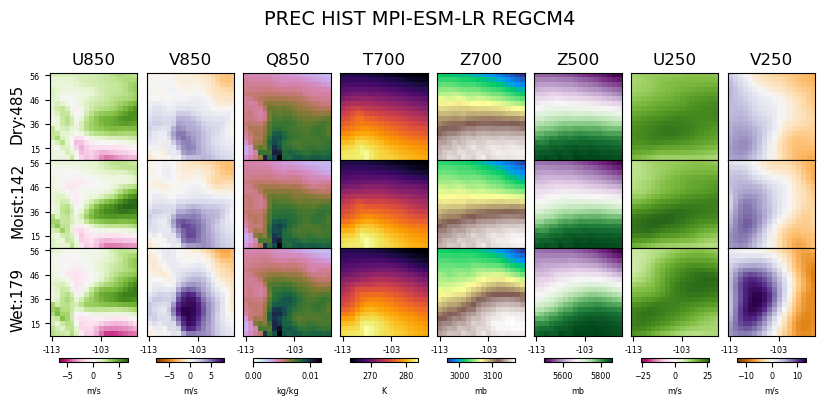

In [20]:
# mpi {dry,moist,wet}: hist
sigfiles_hist = list(filter(lambda line:'hist' in line, sigfiles[0:1]))
plot_models_group_drymoistwet(sigfiles_hist)

# # mpi {dry,moist,wet}: rcp85
# sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, sigfiles[0:1]))
# plot_models_group_drymoistwet(sigfiles_rcp85)

# print('_'*80)


In [8]:
# import warnings
# warnings.filterwarnings("ignore")

# # Do all
# for sii in range(0, len(sigfiles)-1, 2):    # assuming rcp85 always follows hist
# #for sii in range(1):
#     # mpi {dry,moist,wet}: hist
#     sigfiles_hist = list(filter(lambda line:'hist' in line, sigfiles[sii:sii+1]))
#     plot_models_group_drymoistwet(sigfiles_hist)

#     # mpi {dry,moist,wet}: rcp85
#     sigfiles_rcp85 = list(filter(lambda line:'rcp85' in line, sigfiles[sii+1:sii+2]))
#     plot_models_group_drymoistwet(sigfiles_rcp85)

#     print('_'*80)
